In [0]:
# mounting google drive 
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install glove-python
# importing libraries
import numpy as np  
import pandas as pd 
import sys
import re            
from glove import Glove

In [0]:
sys.path.append('/content/drive/My Drive')

In [4]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer
import warnings

from keras import backend as K 
from keras.initializers import Constant 

Using TensorFlow backend.



**Reading Data** 

Read processed articles and summaries generated by DataProcessing.ipynb


In [0]:
import json
fp= open('/content/drive/My Drive/article_highlight_Sample.json', 'r')
content= fp.read()
result=json.loads(content)

In [7]:
#data after preprocessing -
print("After cleaning - ")
print("Article: ", result[str(1)]["article"])
print("Summary:", result[str(1)]["highlight"])
print()

After cleaning - 
Article:  associated press published 14 11 est 25 october 2013 updated 15 36 est 25 october 2013 bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late september early october state health department issued advisory exposure anyone attended five churches took communion bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis state immunization program manager molly howell says risk low officials feel important alert people possible exposure diocese announced monday bishop john folda taking time diagnosed hepatitis diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month symptoms hepatitis include fever tiredness loss appetite nausea abdominal discomfort fargo catholic diocese north dakota pictured bishop located
Summary:  bishop john folda  of nor

**Data** **Analysis**

In [0]:
#Creating dataframe
articles=[]
summaries=[]
d={}

for i, obj in result.items():
  articles.append(obj["article"])
  summaries.append(obj["highlight"])

d["article"]= articles
d["summary"]= summaries

df= pd.DataFrame.from_dict(d)

In [9]:
df.head()

,article,summary
0,associated press published 14 11 est 25 octobe...,bishop john folda of north dakota is taking...
1,ralph mata internal affairs lieutenant miami d...,criminal complaint cop used his role to help...
2,drunk driver killed young woman head crash che...,craig eccleston todd 27 had drunk at least ...
3,breezy sweep pen president vladimir putin wrot...,nina dos santos says europe must be ready to ...
4,leetwood team still 100 record sky bet league ...,fleetwood top of league one after 2 0 win at ...


In [0]:
df['summary'] = df['summary'].apply(lambda x : "_START_ "+ x + " _END_")

**Counting numbers of words in articles and summaries**

In [0]:
article_word_count = []
summary_word_count = []

# word count
for article in df['article']:
      article_word_count.append(len(article.split()))

for summary in df['summary']:
      summary_word_count.append(len(summary.split()))

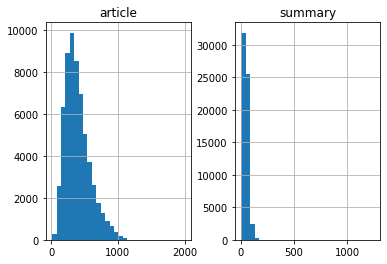

In [12]:
import matplotlib.pyplot as plt
length_df = pd.DataFrame({'article':article_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [13]:
lengths_articles = pd.DataFrame(article_word_count, columns=['counts'])
lengths_summaries = pd.DataFrame(summary_word_count, columns=['counts'])

print("Articles:")
print(lengths_articles.describe())

print("\nSummaries:")
print(lengths_summaries.describe())

Articles:
             counts
count  60000.000000
mean     393.090717
std      187.290512
min       13.000000
25%      256.000000
50%      359.000000
75%      495.000000
max     2000.000000

Summaries:
             counts
count  60000.000000
mean      51.357567
std       20.961405
min        8.000000
25%       38.000000
50%       48.000000
75%       59.000000
max     1247.000000


In [14]:
# Inspect the length of articles
print(np.percentile(lengths_articles.counts, 90))
print(np.percentile(lengths_articles.counts, 95))
print(np.percentile(lengths_articles.counts, 99))

653.0
763.0
945.0


In [15]:
# Inspect the length of summaries
print(np.percentile(lengths_summaries.counts, 90))
print(np.percentile(lengths_summaries.counts, 95))
print(np.percentile(lengths_summaries.counts, 99))

76.0
88.0
117.0


~90 percentile of the articles contain less than 653 words and ~90 percentile of summaries contain less than 74 words

We use this data to set a reasonable value for **max_len_text** and **max_len_summary**

In [0]:
max_len_text= 500
max_len_summary= 70

**Word Embeddings**

We use pre-trained word embeddings from GLoVe 

These word embeddings were generated by training model on Wikipedia 2014 and Gigaword Dataset 

Vocabulary Size: 400,000 words 

Embedding vector dimension: 50


In [0]:
glove= Glove()
model= glove.load_stanford('/content/drive/My Drive/glove.6B.50d.txt')

Printing sample word vectors

In [18]:
model.word_vectors[model.dictionary['woman']]

array([-1.8153e-01,  6.4827e-01, -5.8210e-01, -4.9451e-01,  1.5415e+00,
        1.3450e+00, -4.3305e-01,  5.8059e-01,  3.5556e-01, -2.5184e-01,
        2.0254e-01, -7.1643e-01,  3.0610e-01,  5.6127e-01,  8.3928e-01,
       -3.8085e-01, -9.0875e-01,  4.3326e-01, -1.4436e-02,  2.3725e-01,
       -5.3799e-01,  1.7773e+00, -6.6433e-02,  6.9795e-01,  6.9291e-01,
       -2.6739e+00, -7.6805e-01,  3.3929e-01,  1.9695e-01, -3.5245e-01,
        2.2920e+00, -2.7411e-01, -3.0169e-01,  8.5286e-04,  1.6923e-01,
        9.1433e-02, -2.3610e-02,  3.6236e-02,  3.4488e-01, -8.3947e-01,
       -2.5174e-01,  4.2123e-01,  4.8616e-01,  2.2325e-02,  5.5760e-01,
       -8.5223e-01, -2.3073e-01, -1.3138e+00,  4.8764e-01, -1.0467e-01])

Printing words with similar word embeddings

In [19]:
print(model.most_similar('woman'))

[('girl', 0.9065280671323898), ('man', 0.886033771849582), ('mother', 0.8763704023290443), ('her', 0.8613135031506577)]


In [0]:
# creating embedding dictionary
embeddings_index = {}

for word in model.dictionary:
  embedding = model.word_vectors[model.dictionary[word]]
  embeddings_index[word] = embedding

**Split Data for training and testing**

In [0]:
from sklearn.model_selection import train_test_split

x_tr,x_test,y_tr,y_test = train_test_split(df['article'],df['summary'],test_size=0.1,random_state=0,shuffle=True) 

x_tr,x_val,y_tr,y_val = train_test_split(x_tr,y_tr,test_size=0.1,random_state=0,shuffle=True) 


In [26]:
print('Training data: ', len(x_tr))
print('Validation data: ', len(x_val))
print('Testing data:', len(x_test))

Training data:  48600
Validation data:  5400
Testing data: 6000


**Tokenize Data, create vocabulary**

Article Tokenizer

In [0]:
# Tokenizer library in keras that maps words to integers, integers to words
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))
x_voc_size   =  len(x_tokenizer.word_index) +1

# convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

# padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

Summary Tokenizer

In [0]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))
y_voc_size  =   len(y_tokenizer.word_index) +1

# same for summaries
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

In [0]:
# create embedding matrix to be used in model
embedding_dim= 50

x_embedding_matrix= np.zeros((x_voc_size, embedding_dim))

for word, i in x_tokenizer.word_index.items():
  if i> x_voc_size:
    continue
  embedding_vector= embeddings_index.get(word)

  if embedding_vector is not None:
    x_embedding_matrix[i]= embedding_vector

In [0]:
# embedding matrix for decoder to be used in model
y_embedding_matrix= np.zeros((y_voc_size, embedding_dim))

for word, i in y_tokenizer.word_index.items():
  if i> y_voc_size:
    continue
  embedding_vector= embeddings_index.get(word)

  if embedding_vector is not None:
    y_embedding_matrix[i]= embedding_vector

In [36]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(202657, 50)
(70622, 50)


**Build Model**


In [0]:
latent_dim = 50 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,embeddings_initializer= Constant(x_embedding_matrix), trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
# encoder output 1 is fed as input to the next lstm
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
# encoder output 2 fed as input to next lstm 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 


In [0]:
# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer=  Embedding(y_voc_size, latent_dim,embeddings_initializer= Constant(y_embedding_matrix), trainable=False)
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM 
# Using encoder_states as decoder's initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 


In [39]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 50)      10132850    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500, 50), (N 20200       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [40]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/5
380/380 [==============================] - 379s 999ms/step - loss: 5.7219 - val_loss: 5.0325
Epoch 2/5
380/380 [==============================] - 388s 1s/step - loss: 5.0031 - val_loss: 4.7977
Epoch 3/5
380/380 [==============================] - 390s 1s/step - loss: 4.8200 - val_loss: 4.6705
Epoch 4/5
380/380 [==============================] - 390s 1s/step - loss: 4.7074 - val_loss: 4.5897
Epoch 5/5
380/380 [==============================] - 390s 1s/step - loss: 4.6287 - val_loss: 4.5299


Plotting training and validation error to check over-fitting 

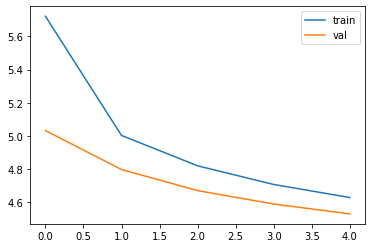

In [41]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='val') 
pyplot.legend()
pyplot.show()

In [0]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [43]:
len(reverse_source_word_index)

202656

In [0]:
# Inference Phase 

"""
After training, the model is tested on new source sequences
for which the target sequence is not known 
setting up inference architecture for it 
"""

# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index in reverse_target_word_index:
          sampled_token = reverse_target_word_index[sampled_token_index]
        else:
          sampled_token="UNK"
          
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [48]:
#print summaries generated
print("Writing results to file")
fp = open("/content/drive/My Drive/Model_summaries.txt",'w')

for i in range(5):
  fp.write("Article:" + seq2text(x_val[i]))
  fp.write("\nOriginal summary:" + seq2summary(y_val[i]))
  fp.write("\nPredicted summary:" + decode_sequence(x_val[i].reshape(1,max_len_text)))
  fp.write("\n")

fp.close()

Writing results to file
